In [26]:
#1: unreliable
#0: reliable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/fake-news/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
print(df.shape)
df = df.dropna()
print(df.shape)

(20800, 5)
(18285, 5)


In [4]:
df['label'].value_counts()

label
0    10361
1     7924
Name: count, dtype: int64

In [5]:
def balance_data(df, label_column_name = 'label'):
    """
    Returns a dataframe with the number of samples of each label equal to the minimum value
    """
    value_counts = df[label_column_name].value_counts()

    # Find the minimum count among the classes
    min_count = value_counts.min()

    # Sample the rows for each class
    balanced_df = pd.concat([
        df[df[label_column_name] == label].sample(min_count, replace=True)
        for label in value_counts.index
    ], ignore_index=True)
    return balanced_df

In [6]:
df_balanced = balance_data(df)

In [7]:
df_balanced['label'].value_counts()

label
0    7924
1    7924
Name: count, dtype: int64

In [8]:
from tqdm import tqdm
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def preprocess_text(txt):
    review = re.sub('[^a-zA-Z]', ' ', txt)
    review = review.lower()
    review = review.split()

    # review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = [word for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

In [10]:
X = df_balanced['title'].values
y = df_balanced['label'].values

In [11]:
X.shape, y.shape

((15848,), (15848,))

In [12]:
X = np.array([preprocess_text(sentence) for sentence in tqdm(X)])

100%|██████████| 15848/15848 [00:23<00:00, 671.50it/s]


In [16]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


In [18]:
vocab_size = 6400
X_indices = [one_hot(input_text = txt, n = vocab_size) for txt in tqdm(X)]
X_indices[:5]

100%|██████████| 15848/15848 [00:00<00:00, 62008.86it/s]


[[819, 4160, 1065, 526, 2941, 1826],
 [3902, 1684, 2500, 4491, 3643, 2590, 1813, 6136, 960],
 [779, 4351, 5054, 918, 5648, 3093, 6160, 3170, 5829, 3352, 1193],
 [2991, 5943, 6120, 4657, 3545, 1449, 4739, 3381, 1826],
 [5671, 5869, 3941, 4455, 1969, 1291, 5829, 3352, 1193]]

In [19]:
MAXLEN = 32
X_indices = pad_sequences(X_indices, maxlen = MAXLEN)

In [20]:
X_indices.shape

(15848, 32)

In [21]:
emb_dim = 28
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=MAXLEN))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 28)            179200    
                                                                 
 lstm (LSTM)                 (None, 64)                23808     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 203073 (793.25 KB)
Trainable params: 203073 (793.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_indices, y, test_size=0.2, random_state=42)

In [23]:
print(X_train.shape, X_test.shape)

(12678, 32) (3170, 32)


In [24]:
unique_elements, counts = np.unique(y_train, return_counts=True)

# Display the unique elements and their counts
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} times")

0: 6330 times
1: 6348 times


In [25]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 15, batch_size = 64)

Epoch 1/15
199/199 [==============================] - 21s 78ms/step - loss: 0.3444 - accuracy: 0.8456 - val_loss: 0.1844 - val_accuracy: 0.9249
Epoch 2/15
199/199 [==============================] - 5s 24ms/step - loss: 0.1028 - accuracy: 0.9658 - val_loss: 0.1737 - val_accuracy: 0.9334
Epoch 3/15
199/199 [==============================] - 3s 13ms/step - loss: 0.0589 - accuracy: 0.9826 - val_loss: 0.1525 - val_accuracy: 0.9514
Epoch 4/15
199/199 [==============================] - 2s 9ms/step - loss: 0.0260 - accuracy: 0.9924 - val_loss: 0.1903 - val_accuracy: 0.9470
Epoch 5/15
199/199 [==============================] - 2s 9ms/step - loss: 0.0122 - accuracy: 0.9972 - val_loss: 0.2105 - val_accuracy: 0.9536
Epoch 6/15
199/199 [==============================] - 1s 7ms/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 0.2332 - val_accuracy: 0.9549
Epoch 7/15
199/199 [==============================] - 2s 9ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.2296 - val_accuracy: 0.9492
Ep

In [29]:
def plot_history(history, metric):
    epochs = list(range(1, 16))
    plt.plot(epochs, history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric}")
    plt.grid()
    plt.show()

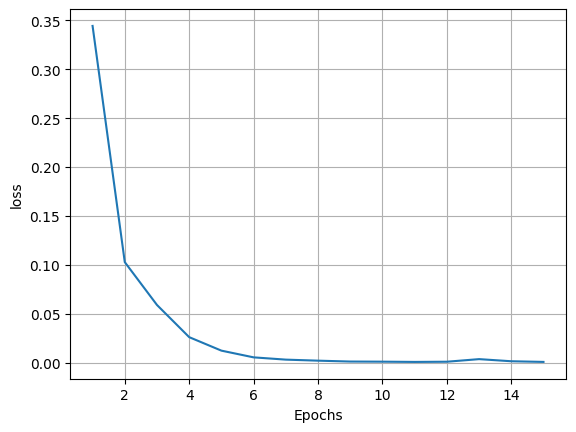

In [30]:
plot_history(history, 'loss')

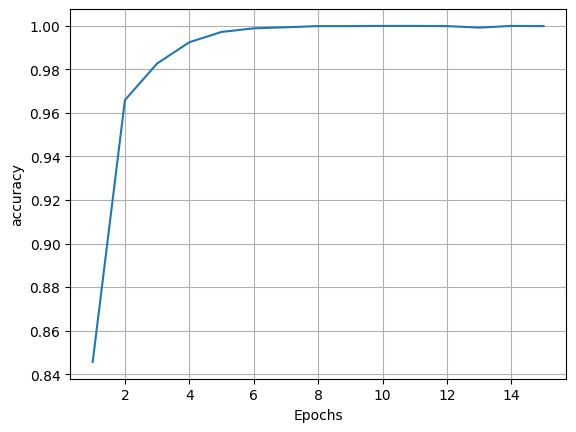

In [31]:
plot_history(history, 'accuracy')

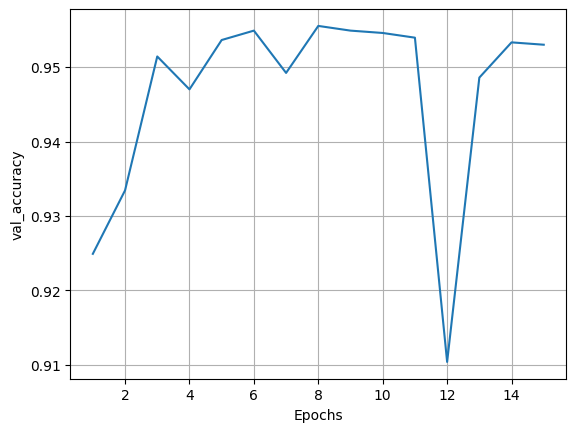

In [32]:
plot_history(history, 'val_accuracy')

In [40]:
def predict_label(X, model, threshold = 0.5):
    y_pred = model.predict(X_test)
    y_pred = np.array([val >= threshold for val in y_pred])
    return y_pred

In [46]:
y_pred = predict_label(X_test, model)

100/100 [==============================] - 0s 2ms/step


In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1515,   79],
       [  70, 1506]])

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9529968454258675

In [50]:
model.save("fake_news_model.keras")